In [129]:
# Based on "The Metrics Manifesto" by Richard Seiersen, Chapter 3 - from ABC (Approximate Bayes Computation) to Canonical Bayes.
# The author used R code, and here's my attempt to "translate" his reasoning and R code to Python.

from scipy.stats import binom
from empiricaldist import Pmf
import numpy as np
import pandas as pd
import seaborn as sns

# variables
sim_phish = 1000000 # number of campaign simulations
campaign_size = 1000 # number of emails in each campaign
df = pd.DataFrame() # create empty dataframe

# get prior_rate, round each result
df['prior_rates'] = [round(test,2) for test in (np.random.uniform(0,1,sim_phish))]

In [72]:
# Each prior_rate (P) results is equally likely (around 3-3.5%) to happen - be it 4% or 78% or 99% - which is of course, not very real. - histogram
# parameters to histplot: stat = "density" shows density of the results P - flat line close to 1 means equally plausible, stat = "probability" will turn Y axis into P of each test;
# default histplot Y is count.

<Axes: ylabel='Density'>

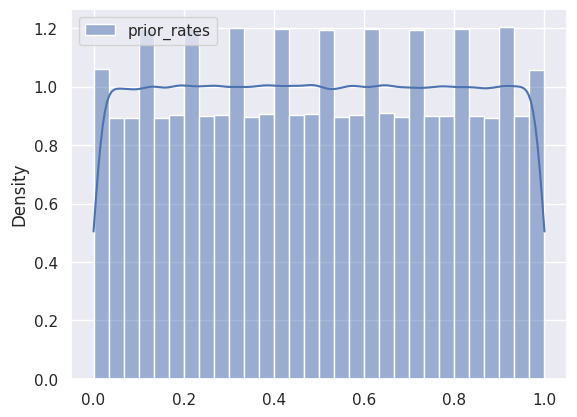

In [130]:
sns.set(color_codes=True)
sns.histplot(df, bins=30, stat="density",kde=True)

<Axes: ylabel='Probability'>

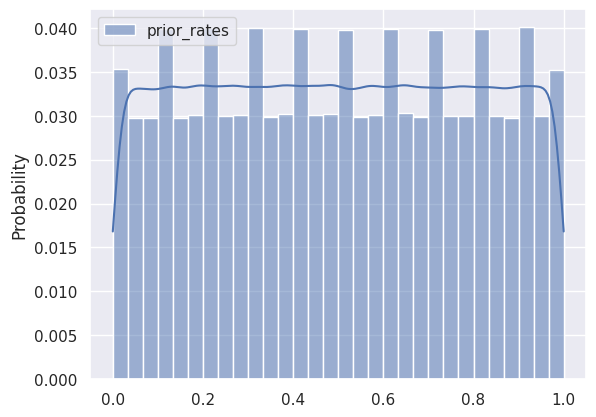

In [131]:
sns.histplot(df, bins=30, stat="probability",kde=True)

<Axes: ylabel='Count'>

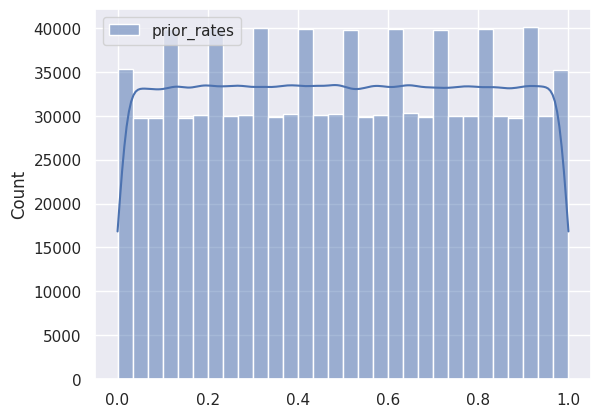

In [132]:
sns.histplot(df, bins=30,kde=True)

In [133]:
# now add another column to the dataset called "phish_chance"
df['phish_chance'] = "NA"

In [134]:
# Now score prior_rates with Phish campaigns using random binomial distribution parametrized with campaign_size and prior_rate (p)
list_of_chances =  [Pmf.from_seq(np.random.binomial(1,size=campaign_size,p=x)).to_list() for x in df['prior_rates']]
df['phish_chance'] = [1-x.pop(0) for x in list_of_chances]

<Axes: xlabel='phish_chance', ylabel='Count'>

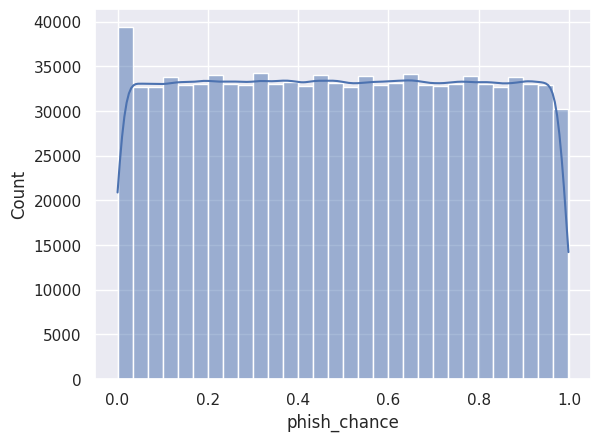

In [137]:
sns.histplot(df['phish_chance'], bins=30,kde=True)

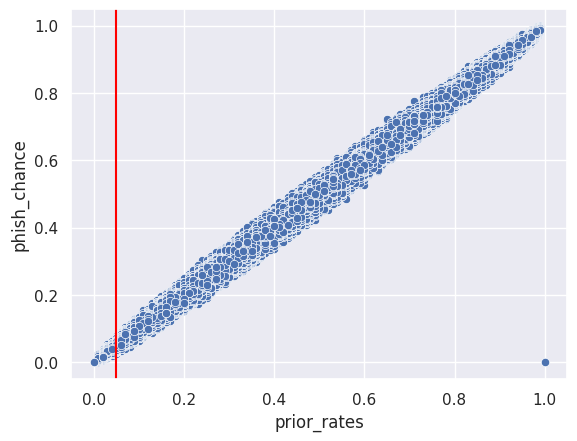

In [138]:
# The scatterplot shows clear correlation between the two series.The red line shows the cluster with up to 5% chances for phishing - this is our belief !
# As we do not think all are equally plausible, only these up to 5% - like, it may happen only in 5 emails in 100 if its send to our users.
import matplotlib.pyplot as plt

sns.scatterplot(df, x=df['prior_rates'],y=df['phish_chance'])
plt.axvline(x=0.05, color="red")

In [139]:
uptofive =  ((df.phish_chance <=0.05) & (df.phish_chance > 0.001))

In [140]:
df_posterior = df[uptofive].prior_rates

In [141]:
df_posterior.head()

0     0.02
18    0.01
51    0.01
63    0.02
87    0.05
Name: prior_rates, dtype: float64

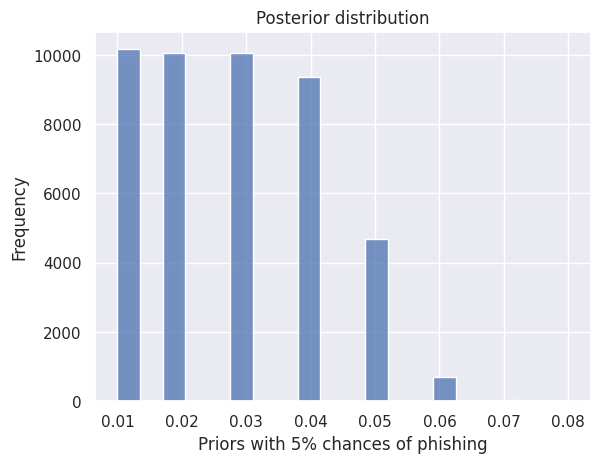

In [142]:
# In the region of up to 5% phish, here is the histogram of the most likely numbers 
ax = sns.histplot(df_posterior, bins=20,kde=False)
ax.set(xlabel='Priors with 5% chances of phishing', ylabel='Frequency', title='Posterior distribution')
plt.show()

In [143]:
# The below number mean that phishing clicks baseline rate exists between 1%-8% - between 1 and 8 clicks per 100 emails.
# with 95% credibility interval (2.5% at the lower bound and 2.5% at the upper bound.
np.quantile(df_posterior, 0.025)

0.01

In [144]:
np.quantile(df_posterior, 0.975)

0.05

In [145]:
# Function to find shape parameters given percentiles/quantiles - we need that for our next prior, where
# someone says "I believe we can get from 1% (with P=0.5) up to 4% (with P=0.9) only".. we need the shape 
# of a beta distribution to see how overall P is distributed.
# taken from: https://www.codeproject.com/articles/56371/finding-probability-distribution-parameters-from-p

import scipy.stats as ss
from scipy import optimize

def find_shape_params(x1,p1,x2,p2):
    def square(x):
        return x*x
    
    def objective(v):
        (a,b) = v
        temp  = square(ss.beta.cdf(x1,a,b) - p1)
        temp += square(ss.beta.cdf(x2,a,b) - p2)
        return temp
    
    xopt = optimize.fmin(objective, (1,1))
    return [xopt[0],xopt[1]]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 79
         Function evaluations: 151


<Axes: xlabel='new_prior_rates', ylabel='Probability'>

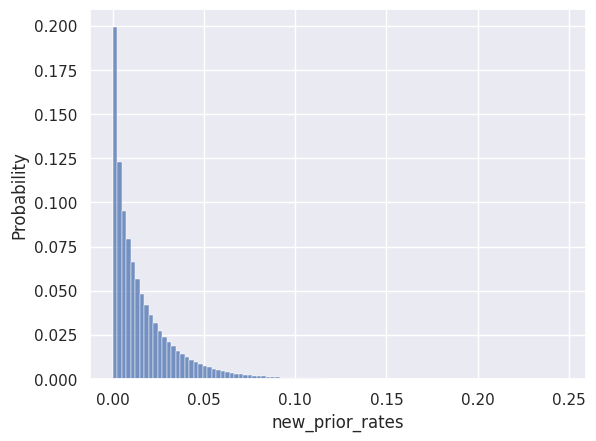

In [146]:
# Now, you show these results to CISO or someone else who's a security expert in your local user community, and he says it's waaay to much - he didn't see more than 5%
# It's close to 4%, yes - between 1 and 4% seems Ok. So, now these informative priors need to be applied to our beliefs and get the model updated.
# We'll use Beta distribution Beta(X) where  0 < X < 1, and a = 0.01, b = 0.04
a,b = find_shape_params(.01,.5,.04,.9)
df['new_prior_rates'] = np.random.beta(a, b, size=sim_phish)
sns.histplot(df['new_prior_rates'], bins=100, stat='probability')

In [92]:
# And now, go from the beginning again..

In [147]:
# now add another column to the dataset called "phish_chance"
df['new_phish_chance'] = "NA"

In [148]:
# Now score prior_rates with Phish campaigns using random binomial distribution parametrized with campaign_size and prior_rate (p)
list_of_chances =  [Pmf.from_seq(np.random.binomial(1,size=campaign_size,p=x)).to_list() for x in df['new_prior_rates']]
df['new_phish_chance'] = [1-x.pop(0) for x in list_of_chances]

In [149]:
uptofive =  ((df.new_phish_chance <=0.05) & (df.new_phish_chance > 0))
df_new_posterior = df[uptofive].new_prior_rates
df_new_posterior.head()

1    0.022798
2    0.014249
3    0.021716
4    0.003723
5    0.019462
Name: new_prior_rates, dtype: float64

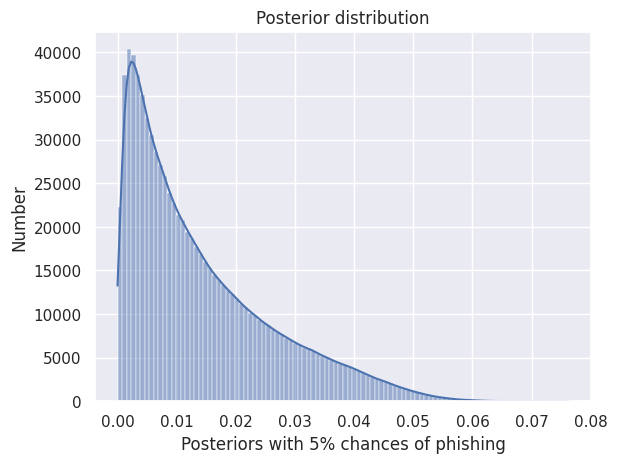

In [150]:
# In the region of up to 5% phish, here is the histogram of the most likely numbers 
ax = sns.histplot(df_new_posterior, bins=100,kde=True)
ax.set(xlabel='Posteriors with 5% chances of phishing', ylabel='Number', title='Posterior distribution')
plt.show()

In [151]:
np.quantile(df_posterior, 0.05)

0.01

In [152]:
np.quantile(df_posterior, 0.95)

0.05

In [275]:
# The last plot can be interpreted to "The most probable P of phish within the interval of 1-5% is around 1%. Or in 5 clicks in 100 emails will happen with about 1% chance.


In [3]:
# Function to find shape parameters given percentiles/quantiles - we need that for our next prior, where
# someone says "I believe we can get from 1% (with P=0.5) up to 4% (with P=0.9) only".. we need the shape 
# of a beta distribution to see how overall P is distributed.
# taken from: https://www.codeproject.com/articles/56371/finding-probability-distribution-parameters-from-p

import scipy.stats as ss
from scipy import optimize

def find_shape_params(x1,p1,x2,p2):
    def square(x):
        return x*x
    
    def objective(v):
        (a,b) = v
        temp  = square(ss.beta.cdf(x1,a,b) - p1)
        temp += square(ss.beta.cdf(x2,a,b) - p2)
        return temp
    
    xopt = optimize.fmin(objective, (1,1))
    return [xopt[0],xopt[1]]
    
a,b = find_shape_params(0.01,.5,0.04,.9)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 79
         Function evaluations: 151


In [153]:
# Continued -----> from ABC to canonical Bayes, prior = 5/100, to uninformed prior (uniform cdf) -> posterior
# create X - p_grid from 0.0001 to 1 by 0.0001 tick; create priors given 1-4% are most likely to happen,
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, beta
import seaborn as sns

clicks = 5
emails = 100
p_grid = [x for x in np.arange(0.0001,1,0.0001)]
prior = beta.pdf(p_grid,a,b)

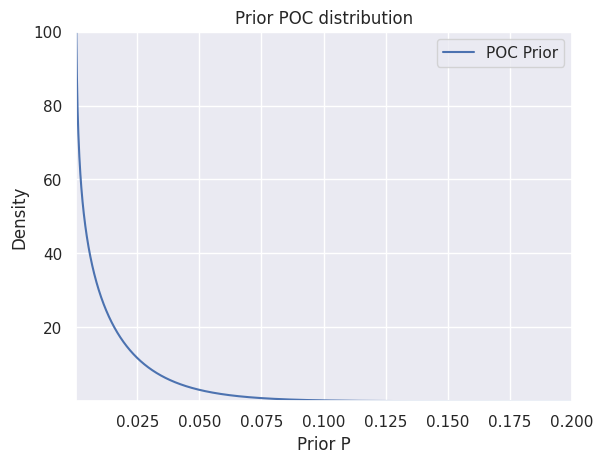

In [154]:
ax=sns.lineplot(x=p_grid,y=prior, label='POC Prior')
ax.set_xlim(0.0001, 0.2)
ax.set_ylim(0.0001,100)
ax.set(xlabel='Prior P', ylabel='Density', title='Prior POC distribution')
plt.show()

In [155]:
# Likelihood of the data - either clicks happened or did not - binomial distribution, probability mass function method
from scipy.stats import uniform, binom
likelihood = binom.pmf(clicks,emails,p_grid)

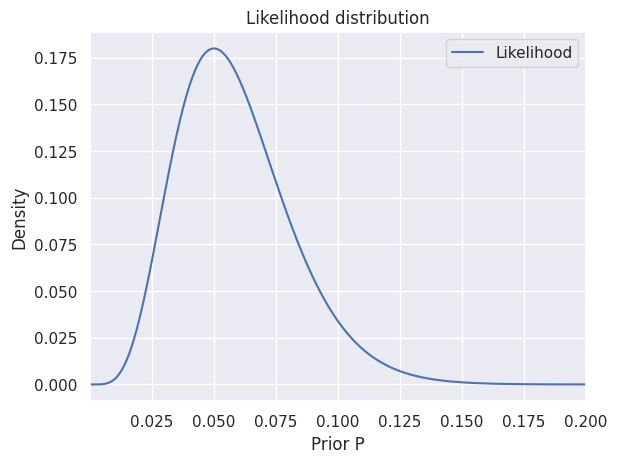

In [156]:
ax=sns.lineplot(x=phish_grid,y=likelihood, label='Likelihood')
ax.set_xlim(0.0001, 0.2)
ax.set(xlabel='Prior P', ylabel='Density', title='Likelihood distribution')
plt.show()

In [157]:
# Multiply POC Priors by likelihood of the data, get the posterior and normalize it.
import pandas as pd

runtb = pd.DataFrame() # create empty dataframe
runtb['p_grid'] = p_grid
runtb['prior'] = prior
runtb['likelihood'] = likelihood
runtb['product'] = runtb['prior']*runtb['likelihood']
runtb['posterior'] = runtb['product']/runtb['product'].sum()

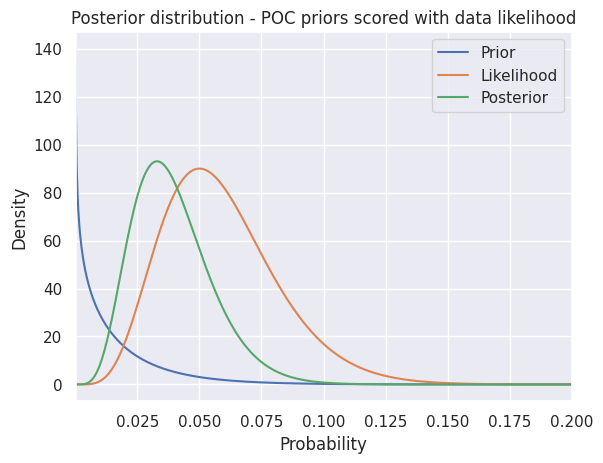

In [158]:
# For a just dirty hack - I am multiplying the results of likelihood and posterior by rough factors 
# so the lines look like scaled alike on this one plot.
ax = plt.subplot()
ax.set_xlim(0.0001,0.2)
sns.lineplot(x=runtb['p_grid'],y=runtb['prior'], label='Prior')
sns.lineplot(x=runtb['p_grid'],y=runtb['likelihood']*500, label='Likelihood') # scale Y by factor 500
sns.lineplot(x=runtb['p_grid'],y=runtb['posterior']*35000, label='Posterior') # Scale Y by factor 35000
ax.set(xlabel='Probability', ylabel='Density', title='Posterior distribution - POC priors scored with data likelihood')
plt.show()

In [159]:
# This way we can verify our initial priors taken from POC (that 5 out of 100 phishing emails gets clicked)
# with some observables here simulated with the likelihood of the data. So ultimately the posterior P is actually closer to 3%